In [3]:
%matplotlib inline
%load_ext rpy2.ipython
from nfl.fdb.const import *
from nfl.fdb import features as nfl_feat
from nfl import storage as nfl_db
import functools
from nfl.sos import calculator as sos
from nfl.sos import profile as sos_profile
from sports_math import markov_chain_rank as mc_rank
from sports_math import scoring as sm_scoring

In [4]:
import imp
imp.reload(nfl_feat)

<module 'nfl.fdb.features' from '/Users/eczech/repos/portfolio/functional/sports/python/nfl/fdb/features.py'>

In [5]:
games = nfl_feat.get_games(None, remove_mirrored_records=True, query={'GameType': 'Regular Season'})

[Mongo] On extraction of document #10000
Removing 482 game records of 10064 due to "OutcomeLink"being null.  Null record counts by year:
Year  GameType      
1995  Regular Season    480
2007  Regular Season      2
dtype: int64


In [6]:
games.head(3)

,Attend,Date,GameType,Location,Opponent,OpponentLink,OutcomeLink,Result,TeamId,Year,GameNumber,OpponentTeamId
0,"48,133",1996-09-01,Regular Season,"RCA Dome (Indianapolis, IN)",@ Indianapolis,/teams/nfl/indianapolis-colts/results/1996,/games/boxscore.html?gid=1996090101,L 20-13,arizona-cardinals,1996,1,indianapolis-colts
28,"55,444",1996-09-08,Regular Season,"Sun Devil Stadium (Tempe, AZ)",Miami,/teams/nfl/miami-dolphins/results/1996,/games/boxscore.html?gid=1996090814,L 38-10,arizona-cardinals,1996,2,miami-dolphins
30,"59,118",1996-09-15,Regular Season,"Foxboro Stadium (Foxborough, MA)",@ New England,/teams/nfl/new-england-patriots/results/1996,/games/boxscore.html?gid=1996091501,L 31-0,arizona-cardinals,1996,3,new-england-patriots


In [7]:
years = [int(y) for y in games['Year'].unique()]
stats = nfl_feat.get_player_stats(games, years)
stats = nfl_feat.clean_player_stats(stats)
stats = stats.drop(['OpponentLink', 'Opponent', 'Result'], axis=1)

[Mongo] On extraction of document #10000
[Mongo] On extraction of document #20000
[Mongo] On extraction of document #30000
[Mongo] On extraction of document #40000
[Mongo] On extraction of document #50000
[Mongo] On extraction of document #60000
[Mongo] On extraction of document #70000
[Mongo] On extraction of document #80000
[Mongo] On extraction of document #90000
[Mongo] On extraction of document #100000
[Mongo] On extraction of document #110000
[Mongo] On extraction of document #120000
[Mongo] On extraction of document #130000
[Mongo] On extraction of document #140000
[Mongo] On extraction of document #150000
[Mongo] On extraction of document #160000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #20000
[Mongo] On extraction of document #30000
[Mongo] On extraction of document #40000
[Mongo] O

In [8]:
rosters = functools.reduce(pd.DataFrame.append, [nfl_feat.get_rosters(y) for y in years])
rosters.head()

[Mongo] On extraction of document #10000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #20000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #20000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #20000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #20000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #20000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #20000
[Mongo] On extraction of document #30000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #20000
[Mongo] On extraction of document #30000
[Mongo] On extraction of document #10000
[Mongo] On extraction of document #20000
[Mongo] On extraction of document #30000
[Mongo] On extra

,Birthdate,College,G:0yr,G:1yr,G:2yr,G:3yr,G:4+yr,GS:0yr,GS:1yr,GS:2yr,GS:3yr,GS:4+yr,Number,Player,PlayerLink,Pos,TeamId,Year
0,1973-05-22 00:00:00,Nebraska,16,0,NaN,NaN,NaN,7,0,NaN,NaN,NaN,,Aaron Graham,/players/aaron-graham-grahaaa01,C,arizona-cardinals,1996
1,1968-01-29 00:00:00,Southern,16,16,NaN,NaN,NaN,16,16,NaN,NaN,NaN,,Aeneas Williams,/players/aeneas-williams-williae01,DB,arizona-cardinals,1996
2,1966-05-26 00:00:00,New Mexico Highlands,16,15,NaN,NaN,NaN,1,0,NaN,NaN,NaN,,Anthony Edwards,/players/anthony-edwards-edwaran03,WR,arizona-cardinals,1996
3,1971-04-09 00:00:00,Auburn,16,12,NaN,NaN,NaN,16,9,NaN,NaN,NaN,,Anthony Redmon,/players/anthony-redmon-redmoan01,OG,arizona-cardinals,1996
4,1967-05-14 00:00:00,Georgia,2,2,NaN,NaN,NaN,0,0,NaN,NaN,NaN,,Ben Smith,/players/ben-smith-smithbe01,DB,arizona-cardinals,1996


In [9]:
id_cols = ['TeamId', 'PlayerLink', 'Year']
roster = rosters[['Player', 'Pos'] + id_cols]
data = pd.merge(stats, roster, on=id_cols)
data = data.append(pd.merge(nfl_feat.swap_direction(stats), roster, on=id_cols))

# Verify that there are now in fact two records for every game, with TeamId
# set to each of the two teams involved in those mirrored pairs
unique_cts = data[['Year', 'Date', 'TeamId', 'OpponentTeamId', 'OutcomeLink']].drop_duplicates()
unique_cts = unique_cts.groupby('OutcomeLink').size().value_counts()
assert len(unique_cts) == 1 and unique_cts.index.values[0] == 2, \
    'Found at least one game record without a mirrored record'

data.head()

,Attend,Date,GameNumber,GameType,Location,Metric,OpponentTeamId,OutcomeLink,Player,PlayerLink,PlayerName,Pos,TeamId,Value,Year
0,"48,133",1996-09-01,1,Regular Season,"RCA Dome (Indianapolis, IN)",defense:Avg,indianapolis-colts,/games/boxscore.html?gid=1996090101,Ben Smith,/players/ben-smith-smithbe01,Ben Smith,DB,arizona-cardinals,0,1996
1,"48,133",1996-09-01,1,Regular Season,"RCA Dome (Indianapolis, IN)",defense:Int,indianapolis-colts,/games/boxscore.html?gid=1996090101,Ben Smith,/players/ben-smith-smithbe01,Ben Smith,DB,arizona-cardinals,0,1996
2,"48,133",1996-09-01,1,Regular Season,"RCA Dome (Indianapolis, IN)",defense:Lg,indianapolis-colts,/games/boxscore.html?gid=1996090101,Ben Smith,/players/ben-smith-smithbe01,Ben Smith,DB,arizona-cardinals,0,1996
3,"48,133",1996-09-01,1,Regular Season,"RCA Dome (Indianapolis, IN)",defense:Sack,indianapolis-colts,/games/boxscore.html?gid=1996090101,Ben Smith,/players/ben-smith-smithbe01,Ben Smith,DB,arizona-cardinals,1,1996
4,"48,133",1996-09-01,1,Regular Season,"RCA Dome (Indianapolis, IN)",defense:TD,indianapolis-colts,/games/boxscore.html?gid=1996090101,Ben Smith,/players/ben-smith-smithbe01,Ben Smith,DB,arizona-cardinals,0,1996


In [404]:
#x = data.Metric.unique()
#[c for c in x if 'Yds' in c or 'Loss' in c]
#sorted(x)

In [403]:
#dt = data.query('Year == 2013 & OpponentTeamId == "seattle-seahawks"')
#dt[dt['Metric'] == 'passing:Yds'].groupby(['TeamId', 'Date'])['Value'].sum().reset_index().sort('Date')

In [204]:
import imp
imp.reload(sos)
imp.reload(sos_profile)
imp.reload(sm_scoring)
imp.reload(mc_rank)

<module 'sports_math.markov_chain_rank' from '/Users/eczech/repos/portfolio/functional/sports/python/sports_math/markov_chain_rank.py'>

In [205]:
profile_list = [
    sos_profile.PROFILE_PASSING, sos_profile.PROFILE_RUSHING, 
    sos_profile.PROFILE_RECEIVING, sos_profile.PROFILE_OVERALL
]

profiles = {}
for profile in profile_list:
    profiles[profile['name']] = {'profile': profile, 'stats': sos.get_matchup_statistics(data, profile)}

In [206]:
profiles['passing']['stats'].reset_index().head()

,Year,Date,GameType,OutcomeLink,TeamId,OpponentTeamId,passing:Rate,passing:YPA,passing:Yds
0,1996,1996-09-01,Regular Season,/games/boxscore.html?gid=1996090101,arizona-cardinals,indianapolis-colts,82.900000,6.200000,226
1,1996,1996-09-01,Regular Season,/games/boxscore.html?gid=1996090101,indianapolis-colts,arizona-cardinals,94.148485,7.509091,238
2,1996,1996-09-01,Regular Season,/games/boxscore.html?gid=1996090102,atlanta-falcons,carolina-panthers,65.800000,6.100000,162
3,1996,1996-09-01,Regular Season,/games/boxscore.html?gid=1996090102,carolina-panthers,atlanta-falcons,95.900000,6.400000,186
4,1996,1996-09-01,Regular Season,/games/boxscore.html?gid=1996090103,cincinnati-bengals,st-louis-rams,61.000000,5.700000,205


In [183]:
def get_sos_basic(year, date, profile, invert=False, damping=.5):
    d = profiles[profile]['stats'].reset_index()
    if invert:
        d = nfl_feat.swap_direction(d)
    d = d[(d['Date'] < date) & (d['Year'] == year)]
    scores = d.groupby('OpponentTeamId')[profiles[profile]['profile']['primary_output']].mean()
    assert scores.isnull().sum() == 0, 'Found null scores in series: {}'.format(scores)
    scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
    if not invert:
        scores = 1 - scores
    scores = scores / np.sum(scores)
    scores = (damping / len(scores)) + (1 - damping) * scores
    return None, None, scores

In [166]:
dates = data.query('Year == 2014')[['Year', 'Date', 'GameNumber']].drop_duplicates().sort('Date')
row = dates.iloc[-1,:]
print(row)
_, _, sos_ranks = get_sos_basic(row['Year'], row['Date'], 'passing', invert=False, damping=.05)


Year                         2014
Date          2014-12-28 00:00:00
GameNumber                     16
Name: 71341, dtype: object


In [167]:
sos_ranks.order()

OpponentTeamId
washington-redskins     0.001563
new-york-jets           0.010281
chicago-bears           0.014296
pittsburgh-steelers     0.014419
tampa-bay-buccaneers    0.014502
oakland-raiders         0.017151
jacksonville-jaguars    0.017798
new-orleans-saints      0.023029
carolina-panthers       0.024444
st-louis-rams           0.025097
minnesota-vikings       0.025152
san-diego-chargers      0.026070
philadelphia-eagles     0.028581
baltimore-ravens        0.028640
kansas-city-chiefs      0.030657
atlanta-falcons         0.030754
new-york-giants         0.031887
tennessee-titans        0.032392
dallas-cowboys          0.033619
indianapolis-colts      0.036764
miami-dolphins          0.037822
new-england-patriots    0.037836
arizona-cardinals       0.038637
denver-broncos          0.038776
houston-texans          0.040801
san-francisco-49ers     0.041522
seattle-seahawks        0.043739
green-bay-packers       0.044806
detroit-lions           0.045309
buffalo-bills           0.05

In [184]:
def get_sos_statistics(year, date, profile, invert=False, damping=.15):
    d = profiles[profile]['stats'].reset_index()
    if invert:
        d = nfl_feat.swap_direction(d)
    scores = sos.get_scores(d, year, date, profiles[profile]['profile'], season_threshold=0).reset_index()
    transitions = sm_scoring.get_normalized_scores(scores, linear=False, 
                                                   less_is_better=not invert, damping_factor=damping)
    ranks = mc_rank.get_ranks(transitions)
    return scores, transitions, ranks

In [169]:
dates = data.query('Year == 2014')[['Year', 'Date']].drop_duplicates().sort('Date')
row = dates.iloc[-1,:]
print(len(dates))
print(row)
sos_scores, sos_trans, sos_ranks = get_sos_statistics(row['Year'], row['Date'], 'passing', 
                                                      invert=False, damping=.05)

50
Year                   2014
Date    2014-12-28 00:00:00
Name: 71341, dtype: object


In [170]:
sos_ranks.order()

OpponentTeamId
washington-redskins     0.023348
pittsburgh-steelers     0.025327
new-york-jets           0.027122
philadelphia-eagles     0.027176
carolina-panthers       0.027507
minnesota-vikings       0.027533
jacksonville-jaguars    0.028110
tampa-bay-buccaneers    0.028190
atlanta-falcons         0.028475
chicago-bears           0.028554
baltimore-ravens        0.029031
oakland-raiders         0.029148
san-diego-chargers      0.029205
denver-broncos          0.029923
kansas-city-chiefs      0.030102
st-louis-rams           0.030302
tennessee-titans        0.030725
detroit-lions           0.031163
new-orleans-saints      0.031310
dallas-cowboys          0.031414
new-york-giants         0.031879
houston-texans          0.032218
arizona-cardinals       0.032287
new-england-patriots    0.033219
indianapolis-colts      0.033273
green-bay-packers       0.033579
miami-dolphins          0.034382
seattle-seahawks        0.035726
buffalo-bills           0.038257
cincinnati-bengals      0.03

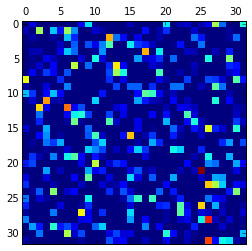

In [134]:
plt.matshow(sos_trans)

In [185]:
def get_sos_timeseries(data, year, damping, min_game_number, profiles, use_basic_method=False):
    dates = data[(data['Year'] == year) & (data['GameNumber'] > min_game_number)]
    dates = dates[['Year', 'Date']].drop_duplicates()
    
    sos_res = []
    print('Processing year {} (Damping = {})'.format(year, damping))
    for profile in profiles:
        for i, row in dates.iterrows():
            for inverted in [True, False]:
                if use_basic_method:
                    _, _, sos_ranks = get_sos_basic(
                        row['Year'], row['Date'], profile, invert=inverted, damping=damping)
                else:
                    sos_scores, sos_trans, sos_ranks = get_sos_statistics(
                        row['Year'], row['Date'], profile, invert=inverted, damping=damping)

                sos_ranks = pd.DataFrame(sos_ranks).T
                sos_ranks['Type'] = profile+':offense' if inverted else profile+':defense'
                sos_ranks['Year'] = row['Year']
                sos_ranks['Date'] = row['Date']
                # Damping values must be used as strings without '.' in
                # order to store them in Mongo as nested keys
                sos_ranks['Damping'] = str(int(damping * 100)) 
                sos_ranks['Inverted'] = inverted
                sos_ranks.columns.name = 'Team'
                sos_res.append(sos_ranks)
    sos_res = functools.reduce(pd.DataFrame.append, sos_res).reset_index(drop=True)
    
    # Replace rows with equal ranks per team if any of the rankings came out to 0
    sos_res = sos_res.set_index(['Type', 'Year', 'Date', 'Damping', 'Inverted'])\
        .fillna(0).apply(lambda x: np.repeat(1/len(x), len(x)) if np.any(x == 0.) else x, axis=1)\
        .sort_index()
    return sos_res

In [136]:
# dt = data[['Year', 'OutcomeLink', 'TeamId', 'OpponentTeamId']].drop_duplicates()\
#     .groupby(['Year', 'OutcomeLink']).size().order()
# dt = dt[dt == 1].reset_index()['OutcomeLink'].unique()
# data[data['OutcomeLink'].isin(dt)][['Year', 'TeamId', 'OpponentTeamId']].drop_duplicates()

In [207]:
sos_res = []
for year in data['Year'].unique():
    #for damping in [.05, .1, .5, .85, .9, .92, .98]: # when using basic=True
    for damping in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
        res = get_sos_timeseries(data, year, damping, 6, profiles.keys(), use_basic_method=False)
        sos_res.append(res)
sos_res = functools.reduce(pd.DataFrame.append, sos_res)
sos_res.columns.name = 'TeamId'

Processing year 1996 (Damping = 0.1)
Processing year 1996 (Damping = 0.2)
Processing year 1996 (Damping = 0.3)
Processing year 1996 (Damping = 0.4)
Processing year 1996 (Damping = 0.5)
Processing year 1996 (Damping = 0.6)
Processing year 1996 (Damping = 0.7)
Processing year 1996 (Damping = 0.8)
Processing year 1996 (Damping = 0.9)
Processing year 1997 (Damping = 0.1)
Processing year 1997 (Damping = 0.2)
Processing year 1997 (Damping = 0.3)
Processing year 1997 (Damping = 0.4)
Processing year 1997 (Damping = 0.5)
Processing year 1997 (Damping = 0.6)
Processing year 1997 (Damping = 0.7)
Processing year 1997 (Damping = 0.8)
Processing year 1997 (Damping = 0.9)
Processing year 1998 (Damping = 0.1)
Processing year 1998 (Damping = 0.2)
Processing year 1998 (Damping = 0.3)
Processing year 1998 (Damping = 0.4)
Processing year 1998 (Damping = 0.5)
Processing year 1998 (Damping = 0.6)
Processing year 1998 (Damping = 0.7)
Processing year 1998 (Damping = 0.8)
Processing year 1998 (Damping = 0.9)
P

# Store Results

In [208]:
#sos_res.loc[('rushing:defense', 2014, '2014-12-27', '90', False)]
sos_res.loc[('rushing:defense', 2014, '2014-12-28', '10', False)].order()

TeamId
cleveland-browns        0.027175
tennessee-titans        0.028087
minnesota-vikings       0.028587
tampa-bay-buccaneers    0.028687
new-york-giants         0.028721
kansas-city-chiefs      0.028901
jacksonville-jaguars    0.028971
san-diego-chargers      0.029381
green-bay-packers       0.029494
cincinnati-bengals      0.029694
miami-dolphins          0.029921
new-orleans-saints      0.029963
philadelphia-eagles     0.030776
carolina-panthers       0.030933
atlanta-falcons         0.031023
washington-redskins     0.031267
indianapolis-colts      0.031371
chicago-bears           0.031548
oakland-raiders         0.031776
houston-texans          0.031844
buffalo-bills           0.031918
st-louis-rams           0.032003
baltimore-ravens        0.032067
san-francisco-49ers     0.032162
new-england-patriots    0.032268
new-york-jets           0.032749
arizona-cardinals       0.033054
dallas-cowboys          0.033072
pittsburgh-steelers     0.033302
seattle-seahawks        0.035131
den

In [209]:
sos_export = sos_res.reset_index()
sos_export = sos_export.drop('Inverted', axis=1)
sos_export.head()

TeamId,Type,Year,Date,Damping,arizona-cardinals,atlanta-falcons,baltimore-ravens,buffalo-bills,carolina-panthers,chicago-bears,...,philadelphia-eagles,pittsburgh-steelers,san-diego-chargers,san-francisco-49ers,seattle-seahawks,st-louis-rams,tampa-bay-buccaneers,tennessee-oilers,tennessee-titans,washington-redskins
0,overall:defense,1996,1996-10-13,10,0.030219,0.029086,0.031176,0.037275,0.035089,0.032389,...,0.034318,0.037302,0.029741,0.032810,0.030725,0.030527,0.028904,NaN,NaN,0.027284
1,overall:defense,1996,1996-10-20,10,0.029798,0.029506,0.033140,0.037059,0.032603,0.032263,...,0.036076,0.037597,0.029498,0.032475,0.030368,0.030007,0.029106,NaN,NaN,0.027294
2,overall:defense,1996,1996-10-27,10,0.029645,0.030239,0.033545,0.036597,0.033183,0.032038,...,0.036426,0.036523,0.029965,0.032045,0.030726,0.029950,0.030616,NaN,NaN,0.027078
3,overall:defense,1996,1996-10-28,10,0.030212,0.030560,0.032778,0.034582,0.033132,0.031948,...,0.036055,0.036339,0.029816,0.034633,0.031205,0.029738,0.031135,NaN,NaN,0.028108
4,overall:defense,1996,1996-11-03,10,0.030212,0.030503,0.032776,0.034583,0.033034,0.032291,...,0.036044,0.036336,0.029810,0.034629,0.031196,0.029737,0.031089,NaN,NaN,0.028103


In [210]:
from nfl.fdb import const as fdb_const

In [211]:
nfl_db.insert_data(fdb_const.DB, fdb_const.COLL_SOS_V1, sos_export, ['Type', 'Damping', 'Year', 'Date'])

Check to see what teams have NA values in strength of schedule rankings:

In [74]:
vals = sos_res.stack(dropna=False)
vals.name = 'Value'
vals = vals.reset_index().groupby(['Year', 'TeamId']).apply(lambda x: 100 * x['Value'].isnull().sum() / len(x))
vals.name = 'PctMissing'
vals[vals > 0].reset_index()

,Year,TeamId,PctMissing
0,1996,cleveland-browns,100
1,1996,houston-texans,100
2,1996,tennessee-oilers,100
3,1996,tennessee-titans,100
4,1997,cleveland-browns,100
5,1997,houston-oilers,100
6,1997,houston-texans,100
7,1997,tennessee-titans,100
8,1998,cleveland-browns,100
9,1998,houston-oilers,100


# Plotting

In [808]:
plt_data = sos_res.reset_index()
plt_data.head()

,Year,Date,arizona-cardinals,atlanta-falcons,baltimore-ravens,buffalo-bills,carolina-panthers,chicago-bears,cincinnati-bengals,cleveland-browns,...,oakland-raiders,philadelphia-eagles,pittsburgh-steelers,san-diego-chargers,san-francisco-49ers,seattle-seahawks,st-louis-rams,tampa-bay-buccaneers,tennessee-titans,washington-redskins
0,1999,1999-10-24,0.037034,0.042120,0.053852,0.040931,0.031698,0.022358,0.033330,0.040059,...,0.020576,0.034072,0.073682,0.031444,0.020741,0.014087,0.020264,0.047343,0.015410,0.007106
1,1999,1999-10-25,0.033559,0.037070,0.050708,0.034485,0.023213,0.028984,0.030673,0.041232,...,0.025097,0.050776,0.064155,0.033180,0.017643,0.015982,0.017990,0.062006,0.013271,0.005784
2,1999,1999-10-31,0.033354,0.051983,0.047088,0.033021,0.024052,0.029778,0.028098,0.038299,...,0.024667,0.050162,0.070388,0.031623,0.017787,0.015442,0.017416,0.061861,0.012497,0.005714
3,1999,1999-11-07,0.037779,0.035730,0.058362,0.071270,0.020387,0.025443,0.023232,0.022092,...,0.036485,0.056973,0.046851,0.023705,0.011024,0.018514,0.012291,0.070264,0.009067,0.005190
4,1999,1999-11-14,0.034337,0.040890,0.058106,0.053294,0.028327,0.022040,0.031683,0.033183,...,0.023731,0.039016,0.074196,0.035843,0.020923,0.015520,0.015274,0.047543,0.019384,0.007436


In [816]:
sos_res.loc[2014]['seattle-seahawks']

Date
2014-10-19    0.019148
2014-10-26    0.032927
2014-10-27    0.035703
2014-10-30    0.034939
2014-11-02    0.029540
2014-11-09    0.028154
2014-11-10    0.027121
2014-11-13    0.027001
2014-11-16    0.026953
2014-11-20    0.043362
2014-11-23    0.044138
2014-11-24    0.052485
2014-11-27    0.052765
2014-11-30    0.077917
2014-12-04    0.075606
2014-12-07    0.074882
2014-12-08    0.086362
2014-12-11    0.086216
2014-12-14    0.086244
2014-12-15    0.083147
2014-12-18    0.082750
2014-12-21    0.074786
2014-12-22    0.069278
2014-12-28    0.069101
Name: seattle-seahawks, dtype: float64